# Big Data

## Table of Contents

* Introduction
  * Visualization tools for large data sets
  * matplotlib and large data sets
* Working with large data sources
  * On the file system with NumPy, Pandas, PyTables, CSV and HDF5
  * On distributed data stores with Hadoop
* Visualizing large data
  * Finding the limits of matplotlib
  * Adjusting limits with configuration
  * Decimation
  * Resampling

Before we get started, let's do our usual warm-up proceedure:

In [1]:
import matplotlib
matplotlib.use('nbagg')
%matplotlib inline

Let's bring in some of the modules we'll be needing as well:

In [2]:
import glob, io, math, os

import psutil

import numpy as np
import pandas as pd
import tables as tb
from scipy import interpolate
from scipy.stats import burr, norm

import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import Image

We can re-use our custom style from a couple notebook ago, too:

In [3]:
plt.style.use("../styles/superheroine-2.mplstyle") 

## Introduction

The term "big data" is semantically ambiguous due to the varying contexts to which it is applied and the motivations of those applying it. The first question that may have occurred to you upon seeing this chapter's title is "how is this applicable to matplotlib or even plotting in general?" Before we answer that question, though, let's establish a working definition of *big data*.

The Wikipedia article on big data opens with the following informal definition: "Big data is a broad term for data sets so large or complex that traditional data processing applications are inadequate." This is a great place to start: it is honest, admitting to being imprecise; it also implies that the definition may change given differing contexts. The words "large" and "complex" are relative, and "traditional data processing" is not going to mean the same thing between different industry segments. In fact, different departments in a single organization may have widely varying data processing "traditions."

The canonical example of big data relates to its origins in web search. Google is generally credited with starting the big data "movement" with the publication of the paper "MapReduce: Simplified Data Processing on Large Clusters" by Dean and Ghemawat. The paper describes the means by which Google was able to quickly search an enormous volume of textual data (crawled web pages and log files, for example) amounting, in 2004, to around 20 TB. In the intervening decade, more and more companies, institutions, and even individuals are faced with the need to quickly process data sets varying in sizes from hundreds of gigabytes to multiples of exobytes. To the small business that used to manage hundreds of megabytes and is now facing several orders of magnitude in data sources for analysis, 250 gigabytes is "big data." For intelligence agencies storing information from untold data sources, even a few terabytes is small; to them, big data is hundreds of petabytes.

To each, though, the general problem remains the same: what worked before on smaller data sets is no longer feasible. New methodologies, new approaches to the use of hardware, communication protocols, data distribution, search, analysis, and visualization -- among many others -- are required. No matter which methodologies are used to support a big data project, one of the last steps in most of them is the presentation of digested data to human eyes. This could be anything from a decision maker to an end-user, but the need is the same: a visual representation of the data collected, searched, and analyzed. This is where tools like matplotlib come into play.

### Visualization tools for large data sets

As stated in previous notebooks, matplotlib was originally designed for use on workstations and desktops, not servers. Its design did not arise from use cases for high-volume or large data sets. However, there are steps you can take that allow for matplotlib to be used in such situations. First, though, here's an overview of tools that *were* designed with large data sets in mind:

* [ParaView](http://www.paraview.org/) -  an open source, multi-platform data analysis and visualization application. ParaView was developed to analyze extremely large datasets using distributed memory computing resources. It can be run on supercomputers to analyze datasets of petascale size as well as on laptops for smaller data. Paraview also offers a Python scripting interface.
* [VisIt](https://wci.llnl.gov/simulation/computer-codes/visit) -  an open source, interactive, scalable, visualization, animation and analysis tool. VisIt has a parallel and distributed architecture allowing users to interactively visualize and analyze data ranging in scale from small ($< 10^1$ core) desktop-sized projects to large ($> 10^5$ core) computing facility simulation campaigns. VisIt is capabable of visualizing data from over 120 different scientific data formats. VisIt offers a Python interface.
* [Bokeh](http://bokeh.pydata.org/en/latest/) - Bokeh is a Python interactive visualization library that targets modern web browsers for presentation. Its goal is to provide elegant, concise construction of novel graphics in the style of D3.js, but also deliver this capability with high-performance interactivity over very large or streaming datasets.
* [Vispy](http://vispy.org/) - a new 2D and 3D high-performance visualization library which can handle very large data sets. Vispy uses the OpenGL library and GPUs for increased performance and with it, users are able to interactively explore plots having hundreds of millions of points. For now, knowledge of OpenGL is very helpful when using Vispy.
 
However, all this being said, matplotlib is a powerful and well-known tool in the scientific computing community. Organizations and teams have uncountable years of cumulative experience building, installing, augmenting, and using matplotlib and the libraries of related projects like NumPy and SciPy. If there is a new way to put old tools to use without having to suffer the losses in productivity and re-engineering of infrastructure associated with platform changes, it is often in everyone's best interest to do so.

### matplotlib and large data sets

In this spirit of adapting established tools to new challenges, the last chapter saw us finding ways to work around matplotlib's limitations on a single workstation. In this chapter, we will explore ways around some of the other limitations matplotlib users may run up against when working on problems with very large data sets. Note that this investigation will often cause us to bump up against the topic of clustering; we will be setting those explorations aside for now, though. Lest you feel that a critical aspect of the problem domain is being ignored, take heart: these will be the topic of the next chapter.

There are two major areas of the problem domain we will cover in this chapter:
 * Preparing large data for use by matplotlib, and
 * Visualizing the prepared data.
 
These are two distinct areas, each with their own engineering problems that need to be solved and we will be taking a look at several options in each area.

## Working with large data sources

Much of the data which users feed into matplotlib when generating plots is from NumPy. NumPy is one of the fastest ways of processing numerical and array-based data in Python (if not *the* fastest), so this makes sense. However, by default, NumPy works in-memory: if the data set you want to plot is larger than the total RAM available on your system, performance is going to plummet.

Let's take a look at an example which illustrates this limitation.

### An example problem

Let's generate a data set with 100 million points.

In [4]:
(c, d) = (10.8, 4.2)
(mean, var, skew, kurt) = burr.stats(c, d, moments='mvsk')

In [5]:
r = burr.rvs(c, d, size=100000000)

That took about 10 seconds to generate, and RAM usage peaked at around 2.25 GB while the data was being generated.

Let's make sure we've got the expected size:

In [6]:
len(r)

100000000

If we save this to a file, it weighs in at about 3/4 of a GB: 

In [8]:
r.tofile("../data/points.bin")

In [9]:
ls -alh ../data/points.bin

-rw-r--r--  1 oubiwann  staff   763M Apr  2 10:04 ../data/points.bin


That actually does fit in memory, but generating much larger files tends to be problematic (on a machine with 8 GB of RAM). We can re-use it multiple times, though, to reach a size that is larger than can fit in the system RAM.

Before we go there, though, let's take a look at what we've got by generating a smooth curve for the probability distribution:

In [7]:
x = np.linspace(burr.ppf(0.0001, c, d),
                burr.ppf(0.9999, c, d), 100)
y = burr.pdf(x, c, d)

Let's try plotting a histogram of the 100,000,000 data points as well as the probablility distribution function:

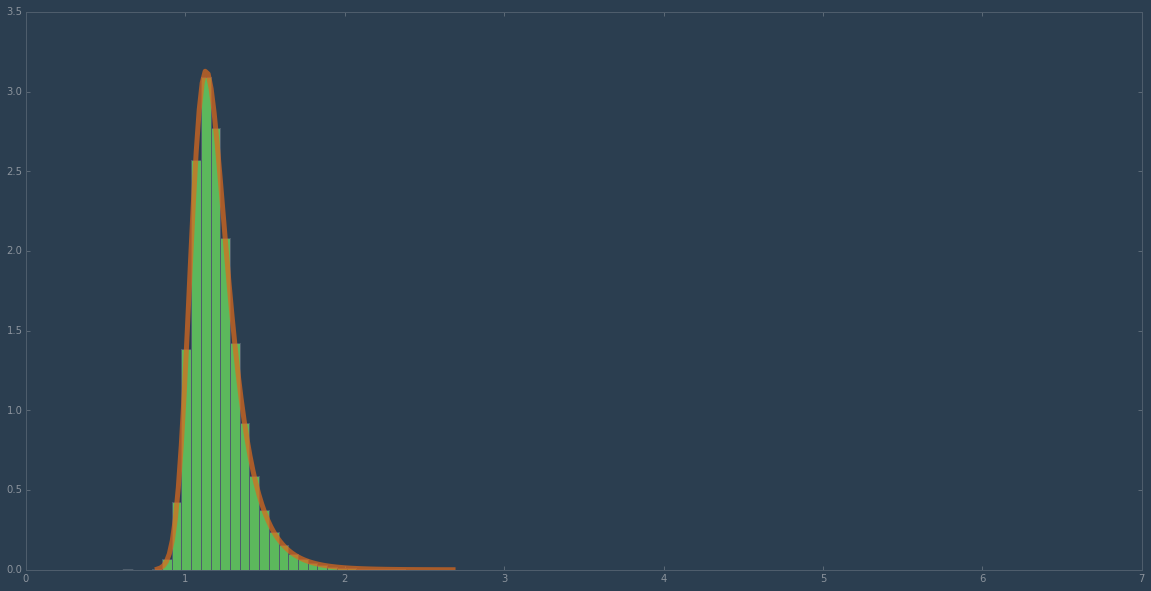

In [10]:
(figure, axes) = plt.subplots(figsize=(20, 10))
axes.plot(x, y, linewidth=5, alpha=0.7)
axes.hist(r, bins=100, normed=True)
plt.show()

Even with 100 million points, that only took about 10 seconds to render. This is due to the fact that NumPy is handling most of the work and we're only displaying a limited number of visual elements. What would happen if we *did* try to plot all 100,000,000 points?

In [11]:
(figure, axes) = plt.subplots(figsize=(20, 10))
axes.plot(r)
plt.show()

/Users/oubiwann/lab/python/mastering-matplotlib/.venv-mmpl/lib/python3.4/site-packages/IPython/core/formatters.py:239: FormatterWarning: Exception in image/png formatter: Allocated too many blocks
  FormatterWarning,


After about 30 seconds of crunching, the above error was thrown: the Agg backend (a shared library on Mac OS X) simply couldn't handle the number of artists required to render all those points. We'll examine this sort of situation towards the end of the chapter and discuss ways of working around it.

But this clarifies the above point for us: our first plot rendered relatively quickly because we were selective about the data we chose to present, given the large number of points we are working with.

So let's say we *do* have data from files that is too large to fit into memory? What can we do? Possible ways of addressing this include:
 * Moving the data out of memory and onto the file system
 * Moving the data off of the file system and into databases

We will explore examples of these below.

### File system

#### NumPy

Let's restart the IPython kernel and re-execute the first few lines above, performing the imports and getting our stylesheet set up. To restart the kernel, in the IPython menu at the top of this page, select "Kernel" and then "Restart".

Once the kernel is restarted, take a look at the RAM utilization on your system for the fresh Python process for the notebook:

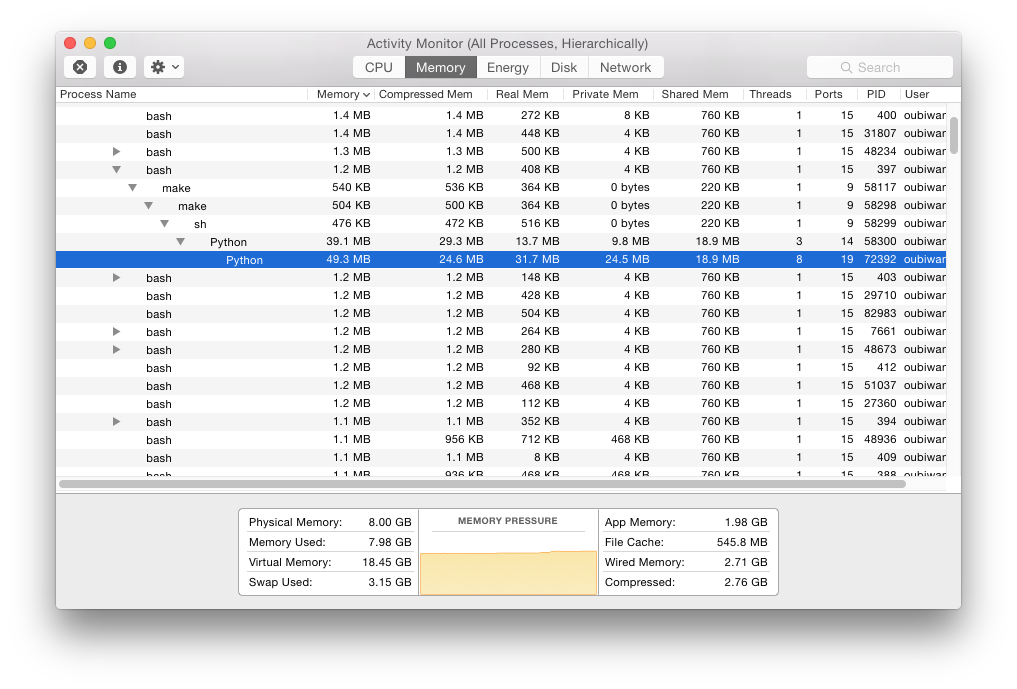

In [4]:
Image("memory-before.png")

Now let's load the array data in and then re-check the memory utilization:

In [5]:
data = np.fromfile("../data/points.bin")
data_shape = data.shape
data_len = len(data)
data_len

100000000

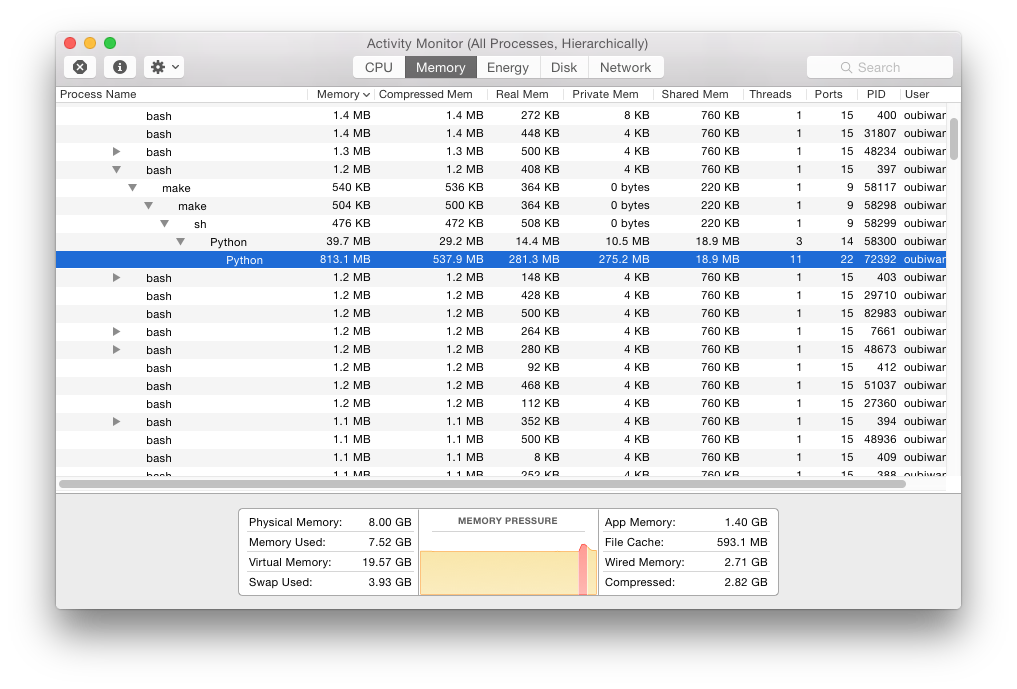

In [6]:
Image("memory-after.png")

That took just a few seconds to load with a memory consumption equivalent to the file size of the data.

That means ... 

In [7]:
8 * 1024

8192

In [8]:
filesize = 763
8192 / filesize

10.73656618610747

... we'd need 11 of those files concatenated to make a file too large to fit in the memory for this system. But that's if all the memory was available. Let's what how much memory we have available right now, after we delete the data we just pulled in:

In [9]:
del data

We'll wait for a few seconds, to let the system memory stabilize, and then check:

In [10]:
psutil.virtual_memory().available / 1024**2

1856.99609375

About 2.5GB. So, to overrun our RAM we'd just need a fraction of the total:

In [11]:
2449 / filesize

3.2096985583224114

Which means we only need 4 of our original files to make something which won't fit in memory. However, below we will still use 11 files to ensure a data that would be much larger than memory if loaded *into* memory.

So, how should we create this large file for demonstration purposes? (Knowing that in a real-life situation, the data would already be 1) created, and 2) potentially quite large.)

We could try to use ``np.tile`` to create a file of the desired size (larger than memory), but that could make our system unusable for a significant period of time. Instead, let's use ``np.memmap`` which will treat a file on disk as an array, thus letting us work with data which is too large to fit into memory.

Let's load the data file again, but this time as a memory-mapped array:

In [12]:
data = np.memmap("../data/points.bin", mode="r", shape=data_shape)

Loading the array to a ``memmap`` object was *very* quick (compared to bringing the contents of the file into memory), taking less than a second to complete.

Now let's create a new file for writing data *to*, sized to be larger than our total system memory (if held in-memory; on disk it will be smaller). 

In [13]:
big_data_shape = (data_len * 11,)
big_data = np.memmap("../data/many-points.bin", dtype="uint8", mode="w+", shape=big_data_shape)

That creates a 1GB file:

In [14]:
ls -alh ../data/many-points.bin

-rw-r--r--  1 oubiwann  staff   1.0G Apr  3 12:43 ../data/many-points.bin


which is mapped to an array having the shape we requested:

In [15]:
big_data.shape

(1100000000,)

and just contains zeros:

In [16]:
big_data

memmap([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

Now let's fill the empty data structure with copies of the data we saved to the 763 MB file:

In [17]:
for x in range(11):
  big_data[x * data_len:((x * data_len) + data_len)] = data
big_data

memmap([ 90,  71,  15, ...,  33, 244,  63], dtype=uint8)

If you check your system memory before and after, you will only see minimal changes, confirming that we are not creating an 8GB data structure in-memory. Furthermore, that only took a few seconds to do.

In [18]:
big_data_len = len(big_data)
big_data_len

1100000000

In [19]:
data[100000000 - 1]

63

In [20]:
big_data[100000000 - 1]

63

Attempting to get the next index from our original data set will throw an error, since it didn't have that index:

In [21]:
data[100000000]

IndexError: index 100000000 is out of bounds for axis 0 with size 100000000

But our new data does:

In [22]:
big_data[100000000]

90

And then some!

In [23]:
big_data[1100000000 - 1]

63

We can also plot data from a ``memmap``ed array without significant lag-times. Note, however, that below we are creating a histogram from 1.1 million points of data, so it won't be *instantaneous* ...

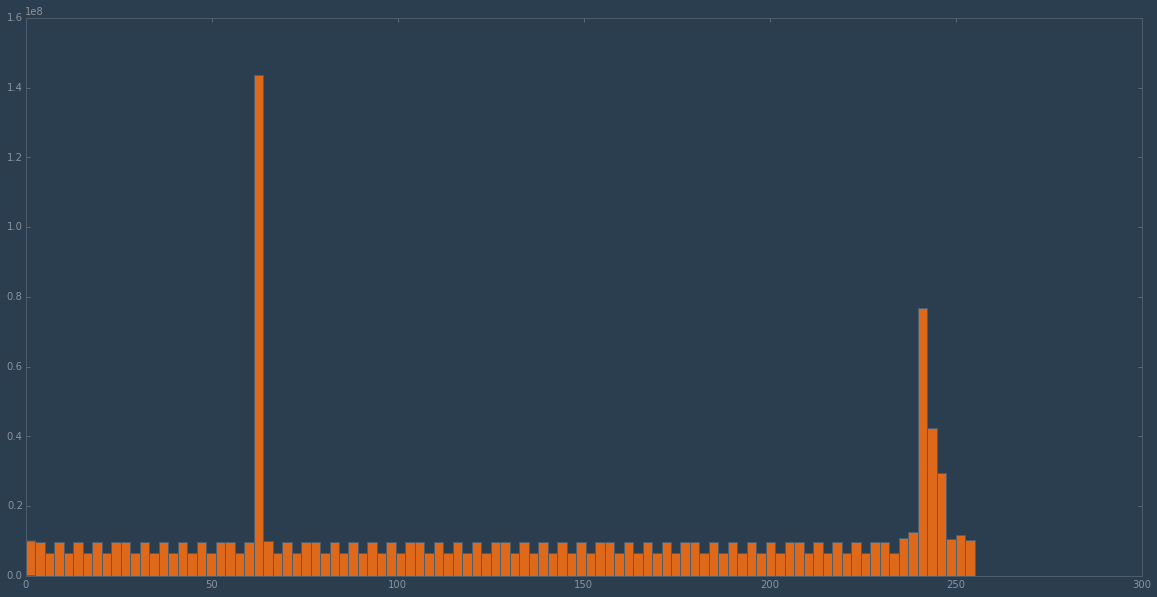

In [24]:
(figure, axes) = plt.subplots(figsize=(20, 10))
axes.hist(big_data, bins=100)
plt.show()

That took about 40 seconds to generate.

Note that with our data file-hacking we have radically changed the nature of our data, since we've increased the sample size linearly without regard for the distribution. The purpose of this demonstration wasn't to preserve a sample distribution, but rather to show how one can work with large data sets.

#### Pandas and PyTables

A few years ago, a [question was asked](http://stackoverflow.com/questions/14262433/large-data-work-flows-using-pandas) on StackOverflow about working with large data in Pandas. It included questions such as:

<blockquote>
What are some best-practice workflows for accomplishing the following:

<ul><li>Loading flat files into a permanent, on-disk database structure?</li>
<li>Querying that database to retrieve data to feed into a pandas data structure?</li>
<li>Updating the database after manipulating pieces in pandas?</li></ul>
</blockquote>

The [answer given](http://stackoverflow.com/a/14268804) by [Jeff Reback](http://stackoverflow.com/users/644898/jeff) was exceptional and is commonly referenced as *the* way to work with very large data sets in Pandas. The question was framed around a desire to move away from proprietary software which handled large data sets well, and the only thinking keeping this person from making the leap was not knowing how to process large data sets in Pandas and NumPy.

Using the scenario outlined, one can easily use tens of GB of file data using the high-performance [HDF5](http://en.wikipedia.org/wiki/Hierarchical_Data_Format) data structure. Pandas [provides documentation](http://pandas.pydata.org/pandas-docs/dev/io.html#hdf5-pytables) on its use of HDF5 in the "I/O" section of its docs site. Jeff provides the following question to consider when defining a workflow for large data files in Pandas and NumPy:

1. What is the size of your data? What are the number of rows and columns? What are the types of columns? Are you appending rows, or just columns?
2. What will typical operations look like? For example, will you be querying columns to select a bunch of rows and specific columns, then doing some in-memory operation, then maybe creating new columns, and finally saving these?
3. After your typical set of operations, what will you do? In other words, is step #2 ad hoc, or repeatable? 
4. Roughly how many total GB are you expecting to process from your source data files? How are these organized? (E.g. by records?) Does each one contain different fields, or do they have some records per file with all of the fields in each file?
5. Do you ever select subsets of rows (records) based on specified criteria (e.g. select the rows with field A > 5)? and then do something? Or do you just select fields A, B, C with all of the records (and *then* do something)?
6. Do you need all of your columns -- as a group -- for all of your typical operations? Or is there a good proportion that you may only use for reports (e.g. you want to keep the data around, but don't need to pull in that column explicity until final results time)?

Jeff's response boils down to a few core concepts:
 * creating a store
 * grouping your fields according to your needs
 * reading large file data in chunks, to prevent swamping system memory
 * reindexing the data (by chunks) and adding it to the store
 * selecting groups from all the chunks that have been saved in the store

##### HDF5, PyTables, and Pandas

[Hierarchical Data Format](http://en.wikipedia.org/wiki/Hierarchical_Data_Format) is a set of file formats (namely HDF4 and HDF5) originally developed at the [National Center for Supercomputing Applications](http://en.wikipedia.org/wiki/National_Center_for_Supercomputing_Applications) to store and organize large amounts of numerical data. (Some may remember NCSA as the place where they downloaded their first graphical web browser, code which is the ancestor not only to the Netscape web browser, but also Internet Explorer. A web server was also created there, and this evolved into the Apache HTTP Server.)

HDF is supported by Python, R, Julia, Java, Octave, IDL, and MATLAB, to name a few. HDF5 offers significant improvements and useful simplifications over HDF4. It uses B-trees to index table objects and, as such, works well for write-once/read-many time series data with common use occurring across fields such as meteorological studies, biosciences, the finance industry, and aviation. HDF5 files of multi-terabyte sizes are common in these applications, typically constructed from the analyses of multiple HDF5 source files, thus providing a single (and often extensive) source of grouped data for a particular application.

The [PyTables](https://pytables.github.io/) library is built on top of the Python HDF5 library and NumPy, thus not only providing access to one of the most widely-used large-data file formats in the scientific computing community, but then links data extracted from these files with the data types and objects provided by the fast Python numerical processing library.

Pandas, in turn, wraps PyTables, thus extending its convenient in-memory data structures, functions, and objects to large on-disk files. To use HDF data with Pandas, you'll want to create a ``pd.HDFStore``, read from HDF data sources with ``pd.read_hdf``, or write to one with ``pd.to_hdf``.

One project to keep an eye on is [Blaze](http://blaze.pydata.org/). It's an open wrapper and utility framework for working with large data sets, generalizing such actions creation, access, updates, and migration. Blaze supports not only HDF, but also SQL, CSV, and JSON. The API usage between Pandas and Blaze is very similar, if various methods are spelled differently. [This page](http://blaze.pydata.org/en/latest/rosetta.html) outlines the basics and is a good review. 

In the example below we will be using PyTables to create an HDF5 too large to comfortably fit in memory. We will follow these steps (for more details and to examine steps that we have left out, be sure to see Yves Hilpisch's presentation [Out-of-Memory Data Analytics with Python](http://hilpisch.com/TPQ_Out_of_Memory_Analytics.html)):
 * Create a series of CSV source data files taking up ~14 GB of disk space
 * Create an empty HDF5 file
 * Create a table in the HDF5 file, providing schema metadata and compression options
 * Load our CSV source data into the HDF5 table
 * Query our new data source, once the data has been migrated

Remember the temperature precipitation data for St. Francis, KS USA from a previous notebook? Let's create fake data sets we can pretend are for temperature and precipitation data for hundreds of thousands of towns across the globe for the last century:

In [25]:
head = "country,town,year,month,precip,temp\n"
row = "{},{},{},{},{},{}\n"
town_count = 1000
(start_year, end_year) = (1894, 2014)
(start_month, end_month) = (1, 13)
sample_size = (1 + 2 * town_count * (end_year - start_year) * (end_month - start_month))
countries = range(200)
towns = range(town_count)
years = range(start_year, end_year)
months = range(start_month, end_month)
for country in countries:
    with open("../data/{}.csv".format(country), "w") as csvfile:
        csvfile.write(head)
        csvdata = ""
        weather_data = norm.rvs(size=sample_size)
        weather_index = 0
        for town in towns:
            for year in years:
                for month in months:
                    csvdata += row.format(
                        country, town, year, month,
                        weather_data[weather_index],
                        weather_data[weather_index + 1])
                    weather_index += 2
        csvfile.write(csvdata)

That took about 35 minutes on my 2009 iMac. Here are the files:

In [26]:
ls -rtm ../data/*.csv

../data/0.csv, ../data/1.csv, ../data/2.csv, ../data/3.csv, ../data/4.csv, ../data/5.csv, ../data/6.csv, ../data/7.csv, ../data/8.csv, ../data/9.csv, ../data/10.csv, ../data/11.csv, ../data/12.csv, ../data/13.csv, ../data/14.csv, 
../data/15.csv, ../data/16.csv, ../data/17.csv, ../data/18.csv, ../data/19.csv, ../data/20.csv, ../data/21.csv, ../data/22.csv, ../data/23.csv, ../data/24.csv, ../data/25.csv, ../data/26.csv, ../data/27.csv, ../data/28.csv, 
../data/29.csv, ../data/30.csv, ../data/31.csv, ../data/32.csv, ../data/33.csv, ../data/34.csv, ../data/35.csv, ../data/36.csv, ../data/37.csv, ../data/38.csv, ../data/39.csv, ../data/40.csv, ../data/41.csv, ../data/42.csv, 
../data/43.csv, ../data/44.csv, ../data/45.csv, ../data/46.csv, ../data/47.csv, ../data/48.csv, ../data/49.csv, ../data/50.csv, ../data/51.csv, ../data/52.csv, ../data/53.csv, ../data/54.csv, ../data/55.csv, ../data/56.csv, 
../data/57.csv, ../data/58.csv, ../data/59.csv, ../data/60.csv, ../data/61.csv, ../data/62.csv

Let's just take a look at one of those:

In [27]:
ls -lh ../data/0.csv

-rw-r--r--  1 oubiwann  staff    72M Mar 21 19:02 ../data/0.csv


Each file is about 72 MB, at 200, that makes about 14 GB -- too much for RAM!

Running queries against so much data in .csv files isn't going to be very efficient: it's going to take a *long* time. So what are our options? Well, for reading this data, HDF5 is a very good fit, designed for jobs like this, in fact. Let's use PyTables to convert our CSV files a single HDF5 file. Note that we aren't using the Pandas ``HDFStore``, since Pandas isn't currently designed to handle exteremly large data sets out of memory. Instead we'll be using PyTables which *has* been designed for such use cases. We'll start by creating an empty table file:

In [28]:
tb_name = "../data/weather.h5t"
h5 = tb.open_file(tb_name, "w")
h5

File(filename=../data/weather.h5t, title='', mode='w', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''

Next we'll need to provide some assistance to PyTables by indicating the data types of each column in our table:

In [29]:
data_types = np.dtype(
    [("country", "<i8"),
     ("town", "<i8"),
     ("year", "<i8"),
     ("month", "<i8"),
     ("precip", "<f8"),
     ("temp", "<f8")])

Let's also define a compression filter to be used by PyTables when saving our data:

In [30]:
filters = tb.Filters(complevel=5, complib='blosc')

Now we can create the table inside of our new HDF5 file:

In [31]:
tab = h5.create_table(
    "/", "weather",
    description=data_types,
    filters=filters)

With that done, let's load each CSV file, reading it by chunks so as not to overload our memory, and then append it to our new HDF5 table:

In [32]:
for filename in glob.glob("../data/*.csv"):
    it = pd.read_csv(filename, iterator=True, chunksize=10000)
    for chunk in it:
        tab.append(chunk.to_records(index=False))
        tab.flush()

That took about 7 minutes on my machine, and what started out as ~14 GB of ``.csv`` files is now a single, compressed 4.8 GB HDF5 file:

In [33]:
h5.get_filesize()

4758762819

Here's the metadata for our PyTables-wrapped HDF5 table:

In [34]:
tab

/weather (Table(288000000,), shuffle, blosc(5)) ''
  description := {
  "country": Int64Col(shape=(), dflt=0, pos=0),
  "town": Int64Col(shape=(), dflt=0, pos=1),
  "year": Int64Col(shape=(), dflt=0, pos=2),
  "month": Int64Col(shape=(), dflt=0, pos=3),
  "precip": Float64Col(shape=(), dflt=0.0, pos=4),
  "temp": Float64Col(shape=(), dflt=0.0, pos=5)}
  byteorder := 'little'
  chunkshape := (1365,)

Let's get some data:

In [35]:
tab[100000:100010]

array([(0, 69, 1947, 5, -0.2328834718674073, 0.06810312195695747),
       (0, 69, 1947, 6, 0.4724989007889187, 1.9529216219569407),
       (0, 69, 1947, 7, -1.0757216683235205, 1.0415374480545465),
       (0, 69, 1947, 8, -1.3700249968748606, 3.0971874991576405),
       (0, 69, 1947, 9, 0.27279758311253083, 0.8263207523831321),
       (0, 69, 1947, 10, -0.0475253104621414, 1.4530808932953758),
       (0, 69, 1947, 11, -0.7555493935762871, -1.2665440609117482),
       (0, 69, 1947, 12, 1.540049376928493, 1.2338186532516708),
       (0, 69, 1948, 1, 0.829743501445512, -0.1562732708511116),
       (0, 69, 1948, 2, 0.06924900463163704, 1.187193711598589)], 
      dtype=[('country', '<i8'), ('town', '<i8'), ('year', '<i8'), ('month', '<i8'), ('precip', '<f8'), ('temp', '<f8')])

In [36]:
tab[100000:100010]["precip"]

array([-0.23288347,  0.4724989 , -1.07572167, -1.370025  ,  0.27279758,
       -0.04752531, -0.75554939,  1.54004938,  0.8297435 ,  0.069249  ])

When you're done, go ahead and close the file:

In [37]:
h5.close()

If you want to work with the data again, simply load it  up:

In [38]:
h5 = tb.open_file(tb_name, "r")
tab = h5.root.weather
tab

/weather (Table(288000000,), shuffle, blosc(5)) ''
  description := {
  "country": Int64Col(shape=(), dflt=0, pos=0),
  "town": Int64Col(shape=(), dflt=0, pos=1),
  "year": Int64Col(shape=(), dflt=0, pos=2),
  "month": Int64Col(shape=(), dflt=0, pos=3),
  "precip": Float64Col(shape=(), dflt=0.0, pos=4),
  "temp": Float64Col(shape=(), dflt=0.0, pos=5)}
  byteorder := 'little'
  chunkshape := (1365,)

Let's plot the first million entries:

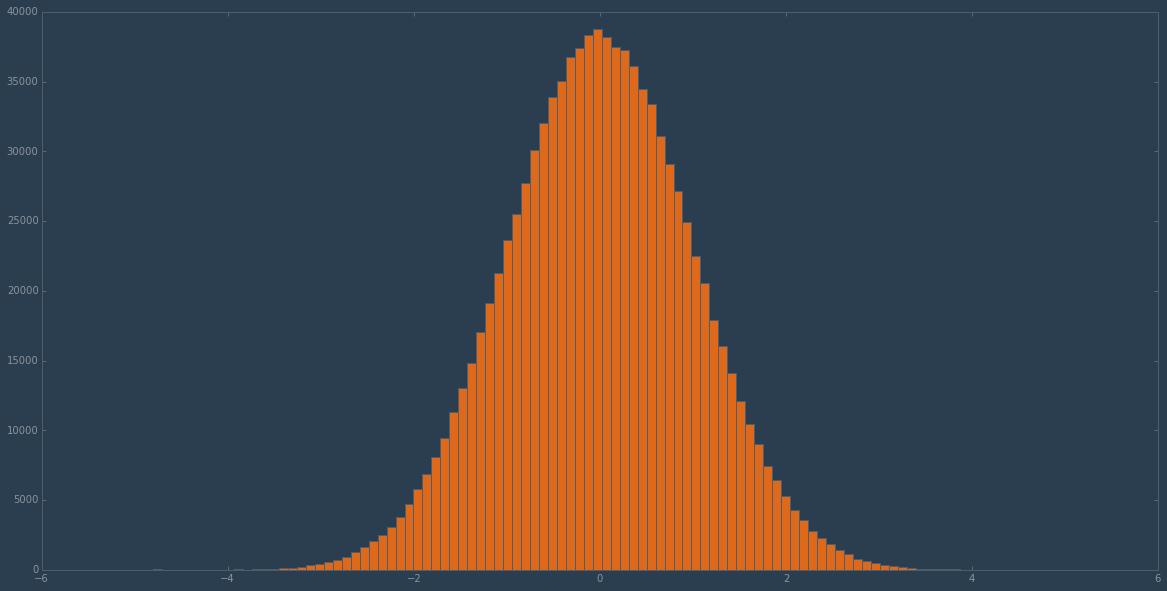

In [39]:
(figure, axes) = plt.subplots(figsize=(20, 10))
axes.hist(tab[:1000000]["temp"], bins=100)
plt.show()

As you can see from this example and from the previous ones, accessing our data via HDF5 files is *exteremely* fast (certainly compared to attempting to use large CSV files).

What about executing calculations against this data? Unfortunately, running the following will consume an enormous amount of RAM:

```python
tab[:]["temp"].mean()
```

We've just asked for all of the data: all 288,000,000 rows of it. That's going to end up loading everything into RAM, grinding the average workstation to a halt. Ideally, though, when you iterate through the source data and to create your HDF5 file, you also crunch the numbers you will need, adding supplemental columns or groups to the HDF5 file for later use by you and your peers.

If we have data which we will mostly be selecting (extracting portions) and which has already been crunched as-needed, grouped as needed, etc., HDF5 is a very good fit. This is why one of the common use cases you see for HDF5 is that of sharing/distributing processed data.

However, if we have data which we will need to process repeatedely, then either we will need to use another method besides that which would cause all the data to be loaded into memory, or find a better match for our data-processing needs. Before we move on, let's give HDF5 another chance...

We saw above that selecting data was very fast in HDF5: what about getting the *mean* for a small section of data, say the first 281,250 rows? (We chose that number since it multiplies nicely to our total of 288,000,000.)

In [40]:
tab[0:281250]["temp"].mean()

0.0030696632864265312

Well, that was fast! What about iterating through all of records in a similar fashion? Let's break up our 288,000,000 records into chunks of that size:

In [41]:
limit = 281250
ranges = [(x * limit, x * limit + limit) for x in range(2 ** 10)]
(ranges[0], ranges[-1])

((0, 281250), (287718750, 288000000))

In [42]:
means = [tab[x * limit:x * limit + limit]["temp"].mean() for x in range(2 ** 10)]
len(means)

1024

That took about 30 seconds to run on my machine.

Of course, once we've taken that step, it's trivial to get the mean value for all 288,000,000 points of temperature data:

In [43]:
sum(means) / len(means)

-5.3051780413782918e-05

Now let's look at another option for handling large data sets.

### Distributed data

We've looked two ways of handling data too large for memory:
 * NumPy's ``memmap``
 * and the more general HDF5 format wrapped by PyTables
 
But there is another situation which may come into play for projects that need to use matplotlib to visual all or parts of large data sets: data which is too large to fit on a *hard drive*. This could be anything from large data sets like those created by super-colliders and radio telescopes to high-volume streaming data used in systems analysis (and social media) and financial markets data. All of these are either too large to fit on a machine or too ephemeral to store, needing to be processed in real-time.

The latter of these is the realm of such projects as [Spark](https://spark.apache.org/), [Storm](https://storm.apache.org/), [Kafka](https://kafka.apache.org/), Amazon's [Kinesis](http://aws.amazon.com/kinesis/). We will not be discussing these in this notebook, but will be instead focusing on the former: processing large data sets in a distirbuted environment, in particular, [map-reduce](https://en.wikipedia.org/wiki/MapReduce). Understanding how to use matplotlib and numpy with a map-reduce framework will provide the foundation necessary for the reader to extend this to the streaming-data scenarios.

Even though we have chosen to example map-reduce, there are many other options for solving problems like these: distributed RDMSs and NoSQL solutions like [Riak](http://basho.com/riak/), [Redis](http://redis.io/), or [Cassandra](http://cassandra.apache.org/) (to name but a few).

#### MapReduce

So what is “MapReduce” and why are we looking at it in the context of running computations against large sets of data? Wikipedia gives the following definition:

<blockquote>
MapReduce is a programming model for processing and generating large data sets with a parallel, distributed algorithm on a cluster. A MapReduce program is composed of a ``Map`` procedure that performs filtering and sorting, and a ``Reduce`` procedure that performs a summary operation. The "MapReduce System" orchestrates the processing by marshalling the distributed servers, running the various tasks in parallel, managing all communications and data transfers between the various parts of the system, and providing for redundancy and fault tolerance.
</blockquote>

A little context will make this more clear and why it is potentially very useful for visualizing large data sets with matplotlib.

(Note that some of the content in the following sub-sections has been taking from the Wikipedia [MapReduce article](http://en.wikipedia.org/wiki/MapReduce) and the Google [MapReduce paper](http://research.google.com/archive/mapreduce.html).)

##### Origins

Between 1999 and 2004, Google had created hundreds of special-purpose computations for processing the huge amounts of data generated by web crawling, HTTP access logs, etc. The many kinds of processing developed were in large part used to create Google search's page ranked search results -- at the time, a vast improvement over other search engine results. Each computation required was pretty straight-forward; it was the combination of these which was unique.

However, in the span of those five years, the computation tasks needed to be split across hundreds and then thousands of machines in order to finish in a timely manner. As such, the difficulties of parallelizing code were introduced: not only the decomposition of tasks into parallelizable parts, but the parallelization of data and hanlding failures. All of these combined with the legacy code being maintain (and created) made for an approach that was becoming less maintainable and growing more difficult to easily add new features.

The inspriation for a new approach to Google's problem came from the second oldest programming language still in use: Lisp (Fortan being the oldest). The authors of the Google MapReduce paper were reminded of the fact that many of their processing jobs consisted of a simple action against a data set (using a [modern Lisp](https://en.wikipedia.org/wiki/LFE_(programming_language)) as an example):

```cl
> (set data "some words to examine")
"some words to examine"
> (lists:map #'length/1 (string:tokens data " "))
(4 5 2 7)
```

And then the "folding" of those results into a secondary analytical result:

```cl
> (lists:foldl #'+/2 0 (4 5 2 7))
18
```

The function above is called "folding" due to the fact that there is a recursive operation in place, with each item in the list being folded into an accumulator. In this case, the folding function is addition (with arity of "2", thus the ``+/2``); ``0`` is provided as an initial value for the first fold. Note that if our folding function created items in a list rather than adding two integers for a sum, the initial value would have been a list (empty or otherwise).

The map and fold operations can be combined in the fashion typical of higher-order functions:

```cl
> (lists:foldl
    #'+/2
    0
    (lists:map
      #'length/1
      data
      (string:tokens data " ")))
18
```

As you might have guessed by now (or known already), there is another term that folding is known. It is named not for the process by which it is created, but by the nature of the results it creates: *reduce*. In this case, a list of integers is reduced to a single value by means of the addition function we provided.

In summary: given an initial data set, we've run a length function (with an arity of one) against every element of our data which has been split on the “space” character. Our results were integers representing the length of each word in our data set. Then, we folded our list with the + function, element at a time, into an “accumulator” with the initial value of zero. The end result represented the sum of all the elements. If we wanted a running average instead of a running sum, we would have supplied a different function: it still would take two arguments and it would still sum them, it would just divide that result by two:

```cl
> (defun ave (number accum)
    (/ (+ number accum) 2))
ave
> (lists:foldl
    #'ave/2
    0
    (lists:map
      #'length/1
      (string:tokens data " ")))
4.875
```

The average word length in our data is 4.875 ASCII characters. This example makes more clear the latent power in solutions like these: for completely new results, we only needed to change one function.

Various Lisps and other functional programming languages have fold or reduce functionality, but this is not just the domain of functional programming: Python 3 has a library dedicated to functional programming idioms: ``functools``. Here's how the above examples would be implemented in Python 3:

```python
>>> data = "some words to examine"
>>> [x for x in map(len, data.split(" ")]
[4, 5, 2, 7]
>>> functools.reduce(operator.add, [4, 5, 2, 7], 0)
18
```
Similarly, these may be composed in Python:

```python
>>> functools.reduce(operator.add,
...                  map(len, data.split(" ")),
...                  0)
18
```

And to calculate the running average:

```python
>>> def ave(number, accum):
...     return (number + accum) / 2
...
>>> functools.reduce(ave,
...                  map(len, data.split(" ")),
...                  0)
4.875
```

The really important part to realize here -- given the context of Google's needs in 2004 and the later fluorescence of MapReduce -- is that each ``map`` call of ``len`` is independent of all the others. These could be called on the same machine in the same process, or in *different processes*, on *different cores*, or on *another machine altogether* (given the appropriate framework, of course). In a similar fashion, the data provided to the ``reduce`` function could be from any number of sources, local or remote. In fact, the reduce step could be split across multiple computational resources -- it would just need a final reduce step to aggregate all the results.

This insight led to an innovation in the development process at Google in support of the tasks which had steadily gown in complexity and reduced maintainability. They created infrastructure such that engineers only needed to create their own mapper and reducer functions, and then these could be run against the desired data sources on the appropriate MapReduce clusters. This automated the parallelization of tasks and distribution of workload across any number of servers running in Google's large computation clusters in their data centers.

##### Optimal Problem Sets

MapReduce programs are not guaranteed to be fast. The main benefit of this programming model is to exploit the optimized algorithms which prepare and process data and results, freeing developers to focus on just the map and reduce parts of the program. In practice, however, the implementation of these can have a heavy impact on the overall performance of tha task in the cluster. When designing a MapReduce algorithm, the author needs to choose a good tradeoff between the computation and the communication costs, and it is common to see communication cost dominating the computation cost.

MapReduce is useful in a wide range of applications, including:
 * distributed pattern-based searching
 * distributed sorting
 * web link-graph reversal
 * Singular Value Decomposition,
 * web access log stats
 * inverted index construction
 * document clustering
 * machine learning
 * statistical machine translation

Moreover, the MapReduce model has been adapted to several computing environments:
 * like multi-core systems
 * desktop grids
 * volunteer computing environments
 * dynamic cloud environments
 * mobile environments



##### The Future for MapReduce

In 2014 Google announced that it had stopped relying upon it for its petabyte-scale operations, having since moved on to technologies such as Percolator, Flume and MillWheel that offer streaming operation and updates instead of batch processing, to allow integrating "live" search results without rebuilding the complete index. Furthermore, these technologies are not limited to the concept of map and reduce workflows, but rather the more general concept of data pipeline workflows.

MapReduce certainly isn't dead, and the frameworks that support it aren't going away. However, we've been seeing an evolution in the industry since Google popularized the concept of distributed workloads across commodity hardware with MapReduce, and both proprietary and open source solutions are offering their users the friuts of these innovations.

#### Open Source Options

Most readers who have even just passing familiarity with big data in general will have heard of Hadoop. A member project of the Apache Software Foundation, Hadoop is an open source distributed storage and processing framework designed to work with very large data sets on commodity hardware computing clusters. The distributed storage part of the project is called HDFS, Hadoop Distributed File System, and the processing part is named MapReduce. When a user uploads data to the Hadoop file system, the files are split into pieces and then distributed across the cluster nodes. When a user creates a code to run on Hadoop MapReduce, the custom mappers and reducers – similar in concept to what we saw in the previous section – are copied to MapReduce nodes in the cluster which are then executed for against the data stored in with that node.

Hadoop's predecessor was created at the Internet Archive in 2002 in an attempt to build a better web page crawler and indexer. When the papers on the Google File System and Google's MapReduce were published in 2003 and 2004, respectively, the creators of Hadoop to re-envision their project and create a framework upon which it could run more efficiently. That was the birth of Hadoop. Yahoo! invested heavily in the project a few years later and open sourced it while at the same time providing its researchers access to a testing cluster – that last was the seed for Hadoop's very strong role in the field of machine learning.

Though Hadoop is the primary driver for the big data market, projected to generate 23 billion USD by 2016, it is not the only big data framework available in the open source community. A notable, if quiet, contender is the Disco project.
In 2008, the Nokia Research Center needed a tool that would allow them to process enormous amounts of data in real-time. They wanted their researchers – many of them proficient in Python – to be able to easily and quickly create MapReduce jobs against their large data sets. They also needed their system to be fault-tolerant and scalable. As such, they built the server on top of the Erlang distributed programming language, and created a protocol and Python client which could talk to it, thus allowing their users to continue using the language they new so well.

Since then, Disco has continued evolving and provides a generalized workflow on top of its distributed file system: Disco pipelines. The pipeline workflow enables data scientists to create distributed processing tasks which go far beyond the original vision of MapReduce.

The functionality of MapReduce is no longer available only in the domain of MapReduce frameworks: the rise of NoSQL databases which then extended their functionality to distributed data have started offering MapReduce features in their products. Redis clusters, for instance, make it trivial to implement MapReduce functionality. The Riak distributed NoSQL key-value data store, based upon the Amazon Dynamo paper (not to be confused with the DynamoDB product from Amazon), offers built-in MapReduce capabilities. Riak provides an API  for executing MapReduce jobs against nodes in a cluster, and this is supported by the Python Riak client library. MongoDB is another NoSQL database which offers built-in support for MapReduce.

In our case, though, we will be focusing on the Hadoop implementation of MapReduce, utilizing its support for Python via its streaming protocol. In particular, we will take advantage of a service provider which allows us to quickly and easily set up Hadoop clusters: Amazon Elastic MapReduce, or EMR.

#### Amazon EMR (Elastic Map Reduce)

In this section we will be using Hadoop on Amazon Elastic MapReduce, performing the following tasks:

* Creating a cluster
* Pushing our data set to the cluster
* Writing a mapper and reducer in Python
* Testing our mapper and reducer against small, local data
* Adding nodes to our EMR cluster in preparation for our job
* Executing our MapReduce job against the EMR cluster we created
* Examining the results

We're going to create an Amazon EMR clusster from the command line using the ``aws`` tool we've installed:

```bash
$ aws emr create-cluster --name "Weather" --ami-version 3.6.0 \
    --applications Name=Hue Name=Hive Name=Pig Name=HBase \
    --use-default-roles --ec2-attributes KeyName=YourKeyName \
    --instance-type c1.xlarge --instance-count 3
```
```
j-63JNVV2BYHC
```

We're going to need that cluster ID, so let's export it as a shell variable. We're also going to need to use the full path to your ``.pem`` file, so we'll set one for that too:

```bash
$ export CLUSTER_ID=j-63JNVV2BYHC
$ export AWS_PEM=/path/to/YourKeyName.pem
```

We can check the state of the cluster with the following:

```bash
$ aws emr describe-cluster --cluster-id $CLUSTER_ID |grep STATUS
STATUS  RUNNING
STATUS  RUNNING
STATUS  WAITING
```

The first ``STATUS`` is the master node, and once it returns as ``RUNNING``, we can start copying files to it:

```bash
$ for FILE in data/{0,1,2}.csv
  do
    aws emr put \
      --src $FILE \
      --cluster-id $CLUSTER_ID \
      --key-pair-file $AWS_PEM
  done
```

Or we can move them all up there (changing to a volume that has more space):

```bash
$ for FILE in data/*.csv
  do
    aws emr put \
      --src $FILE \
      --dest /mnt1 \
      --cluster-id $CLUSTER_ID \
      --key-pair-file $AWS_PEM
  done
```

Login to the server and copy the data to HDFS:

```bash
$ aws emr ssh --cluster-id $CLUSTER_ID --key-pair-file $AWS_PEM
```
```bash
[hadoop@ip-10-255-7-47 ~]$ hdfs dfs -mkdir /weather
[hadoop@ip-10-255-7-47 ~]$ hdfs dfs -put /mnt1/*.csv /weather
```

Let's make sure the files are there:

```bash
[hadoop@ip-10-255-7-47 ~]$ $ hdfs dfs -ls /weather|head -10
Found 200 items
-rw-r--r--   1 hadoop supergroup   75460820 2015-03-29 18:46 /weather/0.csv
-rw-r--r--   1 hadoop supergroup   75456830 2015-03-29 18:47 /weather/1.csv
-rw-r--r--   1 hadoop supergroup   76896036 2015-03-30 00:16 /weather/10.csv
-rw-r--r--   1 hadoop supergroup   78337868 2015-03-30 00:16 /weather/100.csv
-rw-r--r--   1 hadoop supergroup   78341694 2015-03-30 00:16 /weather/101.csv
-rw-r--r--   1 hadoop supergroup   78341015 2015-03-30 00:16 /weather/102.csv
-rw-r--r--   1 hadoop supergroup   78337662 2015-03-30 00:16 /weather/103.csv
-rw-r--r--   1 hadoop supergroup   78336193 2015-03-30 00:16 /weather/104.csv
-rw-r--r--   1 hadoop supergroup   78336537 2015-03-30 00:16 /weather/105.csv
```

Before we write our Python code to process the data now stored in HDFS, let's remind ourselves what the data looks like:
```bash
[hadoop@ip-10-255-7-47 ~]$ head 0.csv
country,town,year,month,precip,temp
0,0,1894,1,0.8449506929198441,0.7897647433139449
0,0,1894,2,0.4746140099538822,0.42335801512344756
0,0,1894,3,-0.7088399152900952,0.776535509023379
0,0,1894,4,-1.1731692311337918,0.8168558530942849
0,0,1894,5,1.9332497442673315,-0.6066233105016293
0,0,1894,6,0.003582147937914687,0.2720125869889254
0,0,1894,7,-0.5612131527063922,2.9628153460517272
0,0,1894,8,0.3733525007455101,-1.3297078910961062
0,0,1894,9,1.9148724762388318,0.6364284082486487
```

Now let's write the *mapper* (saved as ``mapper.py``). This will be used by Hadoop and expects input via ``STDIN``:

```python
#!/usr/bin/env python
import sys

def parse_line(line):
    return line.strip().split(",")

def is_header(line):
    return line.startswith("country")

def main():
    for line in sys.stdin:
        if not is_header(line):
            print(parse_line(line)[-1])

if __name__ == "__main__":
    main()
```

Next we can write the *reducer* (saved as ``reducer.py``):

```python
#!/usr/bin/env python
import sys

def to_float(data):
    try:
        return float(data.strip())
    except:
        return None

def main():
    accum = 0
    count = 0
    for line in sys.stdin:
        temp = to_float(line)
        if temp == None:
            continue
        accum += temp
        count += 1
    print(accum / count)

if __name__ == "__main__":
    main()
```

Make them both executable:
```bash
[hadoop@ip-10-255-7-47 ~]$ chmod 755 *.py
```

Let's test drive the mapper before using it in Hadoop:

```bash
[hadoop@ip-10-255-7-47 ~]$ head 0.csv | ./mapper.py
0.7897647433139449
0.42335801512344756
0.776535509023379
0.8168558530942849
-0.6066233105016293
0.2720125869889254
2.9628153460517272
-1.3297078910961062
0.6364284082486487
```

Let's add the reducer to the mix:

```bash
[hadoop@ip-10-255-7-47 ~]$ head 0.csv | ./mapper.py | ./reducer.py
0.526826584472
```

A quick manual check confirms that the generated average is correct for the values parsed by the mapper.

With our Python code tested and working, we're ready to run it on Hadoop... almost. Since there's a lot of data to process, let's switch to a local terminal session and create some more nodes:

```bash
$ aws emr add-instance-groups \
    --cluster-id $CLUSTER_ID \
    --instance-groups \
      InstanceCount=6,InstanceGroupType=task,InstanceType=m1.large \
      InstanceCount=10,InstanceGroupType=task,InstanceType=m3.xlarge
```
```bash
j-63JNVV2BYHC
INSTANCEGROUPIDS	ig-ZCJCUQU6RU21
INSTANCEGROUPIDS	ig-3RXZ98RUGS7OI
```

Let's check the cluster:

```bash
$ aws emr describe-cluster --cluster-id $CLUSTER_ID
```
```
CLUSTER	False	j-63JNVV2BYHC	ec2-54-70-11-85.us-west-2.compute.amazonaws.com	Weather	189	3.6.0	3.6.0	EMR_DefaultRole	False	True
APPLICATIONS	hadoop	2.4.0
APPLICATIONS	Hue
BOOTSTRAPACTIONS	Install Hue	s3://us-west-2.elasticmapreduce/libs/hue/install-hue
BOOTSTRAPACTIONS	Install HBase	s3://us-west-2.elasticmapreduce/bootstrap-actions/setup-hbase
EC2INSTANCEATTRIBUTES	us-west-2b	OubiwannAWSKeyPair	sg-fea0e9cd	sg-fca0e9cf	EMR_EC2_DefaultRole
INSTANCEGROUPS	ig-3M0BXLF58BAO1	MASTER	c1.xlarge	ON_DEMAND	MASTER	1	1
STATUS	RUNNING
STATECHANGEREASON
TIMELINE	1427653325.578	1427653634.541
INSTANCEGROUPS	ig-1YYKNHQQ27GRM	CORE	c1.xlarge	ON_DEMAND	CORE	2	2
STATUS	RUNNING
STATECHANGEREASON
TIMELINE	1427653325.579	1427653692.548
INSTANCEGROUPS	ig-3RXZ98RUGS7OI	TASK	m3.xlarge	ON_DEMAND	task	10	0
STATUS	RESIZING
STATECHANGEREASON	Expanding instance group
TIMELINE	1427676271.495
INSTANCEGROUPS	ig-ZCJCUQU6RU21	TASK	m1.large	ON_DEMAND	task	6	0
STATUS	RESIZING
STATECHANGEREASON	Expanding instance group
TIMELINE	1427676243.42
STATUS	WAITING
STATECHANGEREASON	Waiting after step completed
TIMELINE	1427653325.578	1427653692.516
```

We can see that the two we just added have a ``STATUS`` of ``RESIZING``. We'll keep an eye on this until they've finished.

Back on the Hadoop cluster, let's execute our map-reduce job against the data we've updated to the cluster and saved to HDFS:

```bash
[hadoop@ip-10-255-7-47 ~]$ hadoop \
  jar contrib/streaming/hadoop-*streaming*.jar \
  -D mapred.reduce.tasks=1 \
  -files mapper.py,reducer.py \
  -mapper mapper.py \
  -reducer reducer.py \
  -combiner reducer.py \
  -input /weather/*.csv \
  -output /weather/total-mean-temp
```

To see the results:

```bash
[hadoop@ip-10-255-7-47 ~]$ hdfs dfs -ls /weather/total-mean-temp
Found 2 items
-rw-r--r--   1 hadoop supergroup          0 2015-03-29 20:20 /weather/total-mean-temp/_SUCCESS
-rw-r--r--   1 hadoop supergroup         18 2015-03-29 20:20 /weather/total-mean-temp/part-00000
[hadoop@ip-10-255-7-47 ~]$ hdfs dfs -cat /weather/total-mean-temp/part-00000
-5.30517804131e-05
```

This is within an order of magnitude of the result obtained by manually slicing the HDF5 file:

In [44]:
sum(means)/len(means)

-5.3051780413782918e-05

Without an in-depth analysis, one might venture a guess that the difference between these two values could be due to floating point calculations on different platforms using different versions of Python (the Python version on the Hadoop cluster was 2.6; we're using 3.4.2). At any rate, the mean calculation meets with expectations: close to zero for a normal distribution centered around zero.

### Hadoop and matplotlib

The standard use case for matplotlib is on a workstation, often at an interactive Python or IPython prompt. In such scenarios, we are used to crunching our data – such as getting means, standard deviations, etc. – and then plotting them, all within a few commands (and seconds) of each other.

In the world of big data, that experience changes drastically. What was an implicit understanding that one's data is in-process, trivial to copy and perform analytical operations upon, is now an involved process comprised of cluster deployments, configuration management, distributed data, communication latencies, and the like. The only thing remaining the same is that its our data, and we need to plot it.

When the data was too large for memory, but still able to fit on a single hard drive, HDF5 and PyTables gave us the means by which we could use our old approaches with very little change in our analytical workflows. Once our data is too large for a hard drive or a file server, those workflows have to change: we can't even pretend it's the same data world we lived in previously. We have to think in terms of partitioned data and our jobs running against those partitions.

We still get to use NumPy, but the work is not being done on our machine in our IPython shell: it's being done remotely on a cluster comprised of distributed nodes. Our work in interactive shells is transformed instead to a testbed where we operate on a small sample set in preparation for pushing out a full job to the cluster. Additionally, every new big data project has the potentially to be legitimately different from any other one. For each organization that needs to work with big data, and for each set of data, the particulars of the day-to-day analytics workflows are likely change.

In the end, though, our jobs will run and we will have distilled from the octillions of data points, the few tens of millions needed in the final analysis, and it is this data which we provide to matplotlib for plotting. Though big data requires that the preparation of data for plotting move outside of the familiarity of an interactive Python prompt, the essence remains the same: we need to know what we have, we need to know how to distill that, and we've got to be able to visualize it.

## Visualizing large data

The majority of this notebook has been dedicated to processing large data sets and plotting histograms. This was done intentionally, since using such an approach limited the number or artists on the matplotlib canvas to something on the order of 100s vs. attempting to plot millions of artists. In this section we will address the problem of displaying actual elements from large data sets. We will return to our fast HDF5 table for the remainder of the notebook.

As a refresher on the volume we're looking at, our data set has the following number of data points:

In [45]:
data_len = len(tab)
data_len

288000000

Adding commas to more easily see the value -- 288,000,000 -- we're looking at almost a third of a billions points.

Let's start with establishing a baseline: is there a practical limit we should consider when attempting to render artists? Let's use the data from our HDF5 file to explore this, starting with 1000 data points:

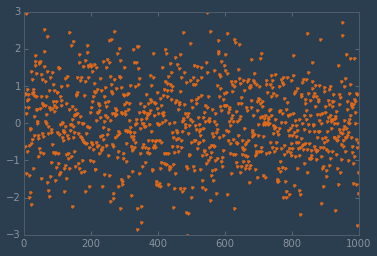

In [46]:
limit = 1000
(figure, axes) = plt.subplots()
axes.plot(tab[:limit]["temp"], ".")
plt.show()

That was quick; maybe something under a second. Let's try 10,000 data points:

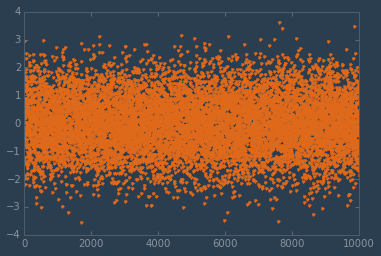

In [47]:
limit = 10000
(figure, axes) = plt.subplots()
axes.plot(tab[:limit]["temp"], ".")
plt.show()

That was still fast -- again, under 1 second to render. 100,000?

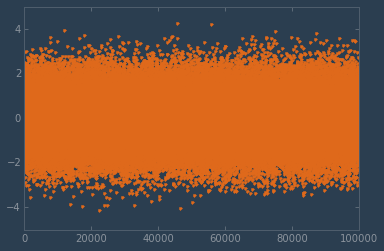

In [48]:
limit = 100000
(figure, axes) = plt.subplots()
axes.plot(tab[:limit]["temp"], ".")
plt.show()

We're starting to see some more time taken; that was about 1 second. Let's keep going:

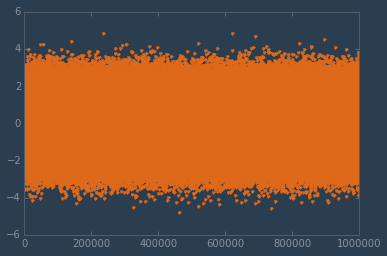

In [49]:
limit = 1000000
(figure, axes) = plt.subplots()
axes.plot(tab[:limit]["temp"], ".")
plt.show()

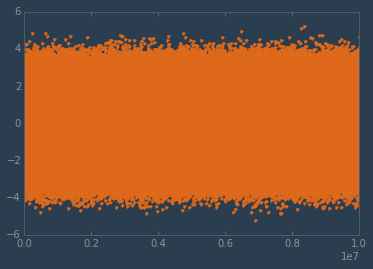

In [50]:
limit = 10000000
(figure, axes) = plt.subplots()
axes.plot(tab[:limit]["temp"], ".")
plt.show()

A million data points only took about 2 or 3 seconds -- not bad for a single plot, but if we had to plot 100s of these, we'd need to start utilizing some of the techniques we discussed in the cloud-deploy notebook. 10 million points took about 15 seconds. Note that if we had used lines instead of points an exception would have been raised -- ``Exception in image/png formatter: Allocated too many blocks`` -- indicating that the shared library we're using for the Agg backend couldn't handle the number of artists required.

100,000 data points looks like a good limit for the number we'd want to plot simultaneously, with no or no appreciable delay in rendering, but that still leaves us with only a fraction of our total data set:

In [51]:
frac = math.floor(data_len / 100000)
frac

2880

How should we procede if we want to plot data points representing our full range of data? We have several options:
 * adjusting matplotlib configuration to use plot chunking
 * decimation
 * (re)sampling
 * data smoothing

### ``matplotlibrc`` Agg Rendering

If you are using the Agg backend and are having issues rendering large data sets, one option is to experiment with the ``agg.path.chuncksize`` configuration variable in your ``matplotlibrc`` file or from a Python interactive prompt using ``rcParams``. Let's try to graph the 10,000,000 data points as lines:

In [52]:
(figure, axes) = plt.subplots()
axes.plot(tab[:10000000]["temp"])
plt.show()

/Users/oubiwann/lab/python/mastering-matplotlib/.venv-mmpl/lib/python3.4/site-packages/IPython/core/formatters.py:239: FormatterWarning: Exception in image/png formatter: Allocated too many blocks
  FormatterWarning,


That generated the error in the backend we talked about above. Let's tweak the chunksize from 0 to 20,000 (a recommended starting point offered in the comments of the ``matplotlibrc`` configuration file):

In [53]:
mpl.rcParams["agg.path.chunksize"] = 20000

And now re-render:

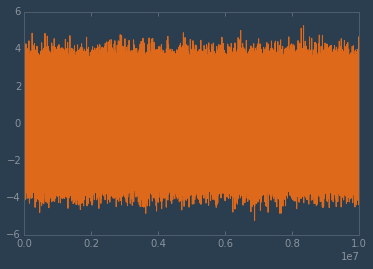

In [54]:
(figure, axes) = plt.subplots()
axes.plot(tab[:10000000]["temp"])
plt.show()

Note that this feature was marked as experimental in 2008 and it remains so. Using it may introduce minor visual artifacts in rendered plot.

More importantly, though, this is a workaround that will allow you to squeeze a little more range out of matplotlib's plotting limits. As your data sets grow in size, you will eventually get to the point where even this configuration change can no longer help.

### Decimation

Another approach carries the unfortunate name of the brutal practice employed by the Roman army against large groups guilty of capital offences: removal of a tenth. We use the term here more generally, indicating "removal of a fraction sufficient to give us our desired performance" -- which, as it turns out, will be much more than a tenth. From our quick calculation above, we determined that we would need no more than every 2880th data point. The following approach brings this into memory:

In [55]:
decimated = tab[::frac]["temp"]

If you know this is something you will be doing, it would be better to generate this data at the time you created your HDF5 table.

Let's sanity check our length:

In [56]:
len(decimated)

100000

Now let's plot the 100,000 data points which represent the full spectrum of our population:

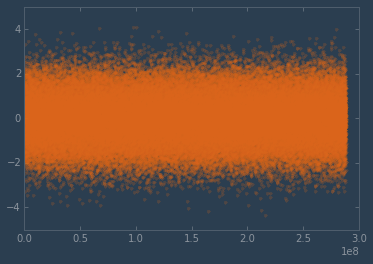

In [57]:
xvals = range(0, data_len, frac)
(figure, axes) = plt.subplots()
axes.plot(xvals, decimated, ".", alpha=0.2)
plt.show()

Things to keep in mind:
 * potentially important data points can be eliminated in this method
 * depending on the type of distribution, standard deviation, variance, and other statistical values could very well change in the decimated data set
 
If these are important to you, you still have some other options available.

### Resampling

If your data is random, then you can simply take a slice of the desired number of points:

In [61]:
[size] = tab[0:limit]["temp"].shape
size

10000000

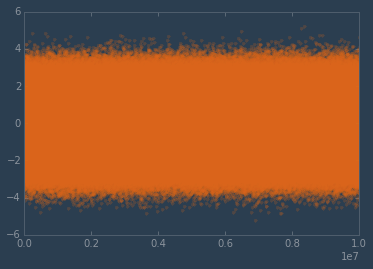

In [62]:
(figure, axes) = plt.subplots()
axes.plot(range(size), tab[0:limit]["temp"], ".", alpha=0.2)
plt.show()

This, by nature of PyTables, is a very fast option.

If your data is periodic, it might be worth trying ``scipy.signal.resample``.

## Summary

The most important thing to keep in mind when working with large data sets and matplotlib is this: use the data wisely and take advantage of NumPy. As we saw, even with data sets approaching billions of points, matplotlib's use of NumPy was intelligent and didn't do anything untoward under the hood: when we used ``memmap``, matplotlib used it. More importantly, in the early art of this notebook we decided to plot the histogram, not the entire data set. A little discernment on our part went a long way and made matplotlib highly usable even under circumstances that it was never designed to handle.